# **COSC2626 Machine Learning Assignment 2**
# **Colon Cancer Histopathology Image Classification**

**Merve-Nur Soylu** | s3794687  
**Sefa Nur Soylu** | s3794642  

---

# **Introduction**

- Early and accurate detection of colon cancer plays a critical role in improving patient outcomes.
- In this project, we use the **CRCHistoPhenotypes** dataset, which consists of labeled colon histopathology image patches.
- The dataset supports two tasks:
  - **Task 1**: Binary classification — cancerous vs. not cancerous
  - **Task 2**: Multi-class classification — cell type (fibroblast, inflammatory, epithelial, others)
- Our goal is to build an end-to-end deep learning pipeline using CNNs, justify each design choice, and evaluate performance thoroughly using relevant metrics.

---

# **Approach**
## **Data Exploration & Understanding**

- For Task 1, we use both Main and Extra labels to train and test the models (combined_labels). This is done as both main and extra have the isCancerous column which we can make use of for training as more data can help.
- For Task 2, we only use Main labels to train and validate as it contains the cellType columns.



In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# ------------------- Load and preprocess labels -------------------

# Load label files
main_labels = pd.read_csv('data_labels_mainData.csv')
extra_labels = pd.read_csv('data_labels_extraData.csv')
combined_labels = pd.concat([main_labels, extra_labels], ignore_index=True)

# Image folder
image_folder = "C:/Users/golde/Downloads/Image_classification_data/patch_images"


### **Class Imbalance Identification**
- We use count plots to display if there are imbalances in the classes for both Task 1 (Cancerous) and Task 2 (Cell Type)

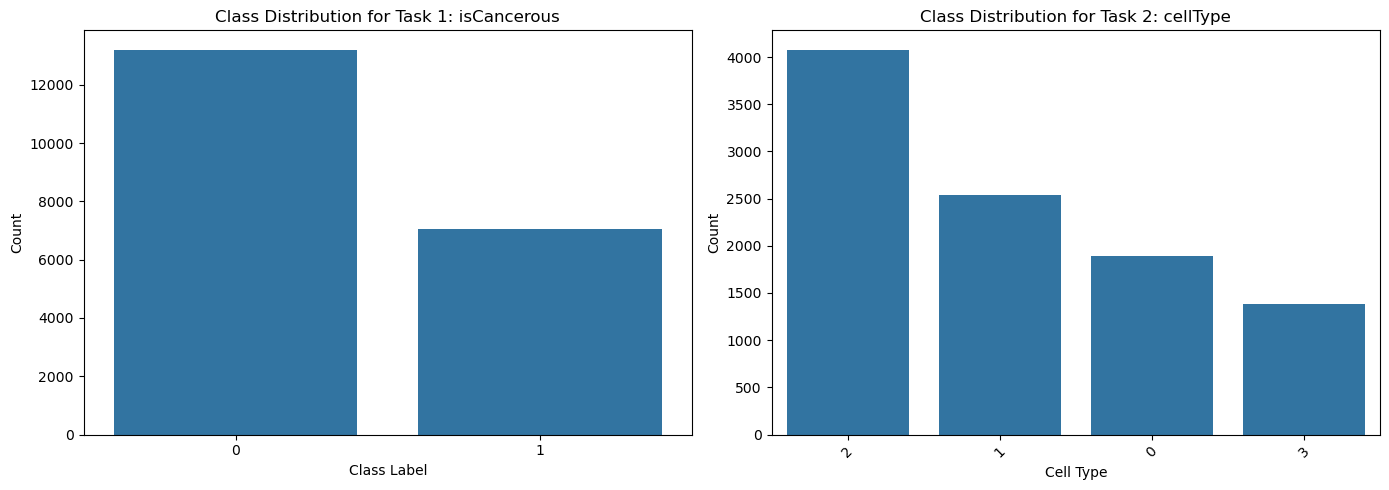

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Task 1: isCancerous
sns.countplot(data=combined_labels, x='isCancerous', ax=axs[0])
axs[0].set_title("Class Distribution for Task 1: isCancerous")
axs[0].set_xlabel("Class Label")
axs[0].set_ylabel("Count")

# Plot for Task 2: cellType
sns.countplot(data=main_labels, x='cellType', order=main_labels['cellType'].value_counts().index, ax=axs[1])
axs[1].set_title("Class Distribution for Task 2: cellType")
axs[1].set_xlabel("Cell Type")
axs[1].set_ylabel("Count")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Task 1: The isCancerous labels are imbalanced, with many more non-cancerous (0) samples than cancerous (1). This could lead the model to favor predicting '0', reducing sensitivity to actual cancer cases.

- Task 2: The cellType distribution is uneven, with some types underrepresented. This imbalance may cause the model to perform poorly on those minority classes.

### **Exploratory Data Analysis**
- We display an even number of images from the data per unique class
- Task 1: 8 images, 4 non-cancerous & 4 cancerous
- Task 2: 8 images, 2 per category (0 = fibroblast, 1 = inflammatory, 2 = epithelial, 3 = others)

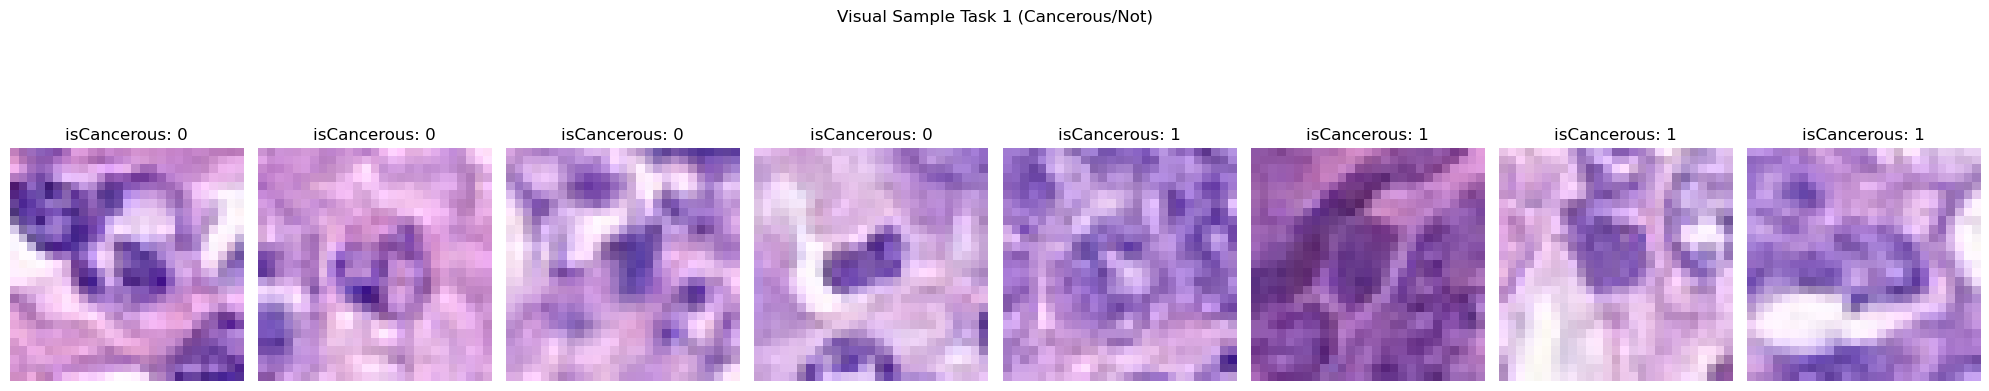

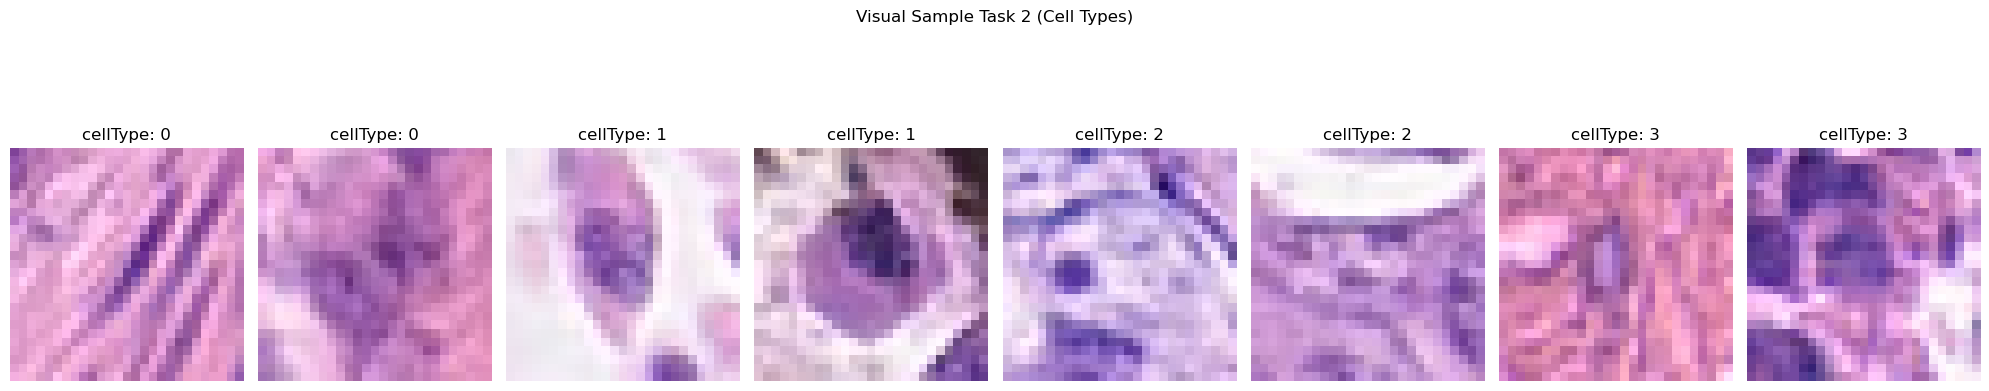

In [3]:
# ------------------- Visual Samples -------------------
def show_visual_sample(label_df, label_col, image_folder, title, samples_per_class, n=8):
    unique_classes = label_df[label_col].unique()
    num_classes = len(unique_classes)
    total_samples = samples_per_class * num_classes

    plt.figure(figsize=(2.5 * total_samples, 5))

    i = 1
    for class_value in sorted(unique_classes):
        class_subset = label_df[label_df[label_col] == class_value]
        sample_df = class_subset.sample(samples_per_class)

        for _, row in sample_df.iterrows():
            img_path = os.path.join(image_folder, row['ImageName'])
            img = Image.open(img_path).convert("RGB")
            plt.subplot(1, total_samples, i)
            plt.imshow(img)
            plt.title(f"{label_col}: {row[label_col]}")
            plt.axis('off')
            i += 1

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Task 1: Show 4 cancerous (1) and 4 non-cancerous (0)
show_visual_sample(
    label_df=combined_labels,
    label_col='isCancerous',
    image_folder=image_folder,
    title='Visual Sample Task 1 (Cancerous/Not)',
    samples_per_class=4
)

# Task 2: Show 2 samples from each cell type (0, 1, 2, 3)
show_visual_sample(
    label_df=main_labels,
    label_col='cellType',
    image_folder=image_folder,
    title='Visual Sample Task 2 (Cell Types)',
    samples_per_class=2
)

#### **Potential Issues**
- Some images appear blurry or low-resolution, which may affect fine-grained feature recognition.
- Over-saturation or uneven staining in certain patches could distort color-based features.
- A few images lack clear cell morphology, making it difficult even for human interpretation—this may challenge the model's ability to learn meaningful patterns.

### **Preprocessing Steps**
- For both tasks, we normalized pixel values by rescaling to the 0,1 range using ImageDataGenerator(rescale=1./255). This helps speed up convergence during training and ensures consistent input ranges for the model.

- No data augmentation was applied in the baseline model to establish a clean benchmark. Augmentation will be added later when improving upon these models.

In [4]:
# ------------------- Task 1: Cancerous classification -------------------

# Stratified splitting
train_labels_t1, temp_labels_t1 = train_test_split(
    combined_labels, test_size=0.3, random_state=42, stratify=combined_labels['isCancerous']
)
val_labels_t1, test_labels_t1 = train_test_split(
    temp_labels_t1, test_size=0.5, random_state=42, stratify=temp_labels_t1['isCancerous']
)

# Flow generators expect string labels
for df in [train_labels_t1, val_labels_t1, test_labels_t1]:
    df['isCancerous'] = df['isCancerous'].astype(str)

# ------------------- Task 2: Cell type classification -------------------

# Only use main_labels for this task
train_labels_t2, temp_labels_t2 = train_test_split(
    main_labels, test_size=0.3, random_state=42, stratify=main_labels['cellType']
)
val_labels_t2, test_labels_t2 = train_test_split(
    temp_labels_t2, test_size=0.5, random_state=42, stratify=temp_labels_t2['cellType']
)

# Flow generators expect string labels
for df in [train_labels_t2, val_labels_t2, test_labels_t2]:
    df['cellType'] = df['cellType'].astype(str)

# ------------------- Define ImageDataGenerators -------------------

# Normalize training set
train_datagen_baseline = ImageDataGenerator(rescale=1./255)

# Normalize testing set
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen_t1_baseline = train_datagen_baseline.flow_from_dataframe(
    dataframe=train_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t1_baseline = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_gen_t1_baseline = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)
# ------------------- Flow generators (Task 2) -------------------

train_gen_t2 = train_datagen_baseline.flow_from_dataframe(
    dataframe=train_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t2 = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen_t2 = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 14196 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.
Found 6927 validated image filenames belonging to 4 classes.
Found 1484 validated image filenames belonging to 4 classes.
Found 1485 validated image filenames belonging to 4 classes.


## **Evaluation Framework**
### **Performance Metric Selection**
For both tasks, we evaluate performance using F1-score and accuracy.
- F1-score is prioritized due to the class imbalance present in both tasks. It balances precision and recall, making it more informative than accuracy when one class dominates.
- Accuracy is included as a secondary metric for general interpretability but may be misleading on imbalanced data.

### **Data Splitting Strategy**
- We split the data into 70% train, 15% validation, and 15% test, using stratified sampling to keep the class balance consistent across all sets. Since both tasks have imbalanced classes, this helps avoid issues where some classes are missing or underrepresented in one of the splits.
- The training set gives the model plenty to learn from, the validation set helps us tune things during training without touching the test set, and the test set gives us a fair way to check how well the model performs on unseen data.

### **Prevent Data Leakage**
Without patient-level splitting, there’s a risk of data leakage if patches from the same patient appear in both training and evaluation sets.

This can lead to overly optimistic performance, since the model may learn patient-specific features rather than generalizable patterns.
A better approach would be to group by patient ID and split at that level, ensuring all patches from a single patient stay in one set. This would help prevent leakage and give a more realistic measure of how well the model generalizes to unseen patients.

# **Task 1 Models**
## **Base Model Selection**
- CNNs are specifically designed for image data. Unlike traditional models like MLPs, which treat input as flat vectors, CNNs use convolutional layers to learn spatial hierarchies and local patterns (like edges, textures, and shapes) that are crucial for interpreting medical images.
- Detecting cancerous regions often depends on subtle textural and morphological patterns in the tissue. CNNs are proven to outperform MLPs and other basic classifiers in this domain because they can extract these local features more effectively.

- The model below is intentionally shallow, with only 5 layers.
- It’s trained using the baseline train/validation data, which has only been normalized (no augmentation applied).
- We limited training to 10 epochs to keep things simple and focus on benchmarking the base performance.

In [5]:
# ------------------- Define Baseline CNN Model -------------------
baseline_model_t1 = Sequential([
    InputLayer(input_shape=(27, 27, 1)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

baseline_model_t1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

baseline_model_t1.summary()

# ------------------- Train the Baseline Model -------------------

baseline_history = baseline_model_t1.fit(
    train_gen_t1_baseline,
    validation_data=val_gen_t1_baseline,
    epochs=10,
    verbose=0
)
print("Baseline Model Training Completed")

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 27, 27, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2704)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,865 (11.19 KB)

 Trainable params: 2,865 (11.19 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Baseline Model Training Completed


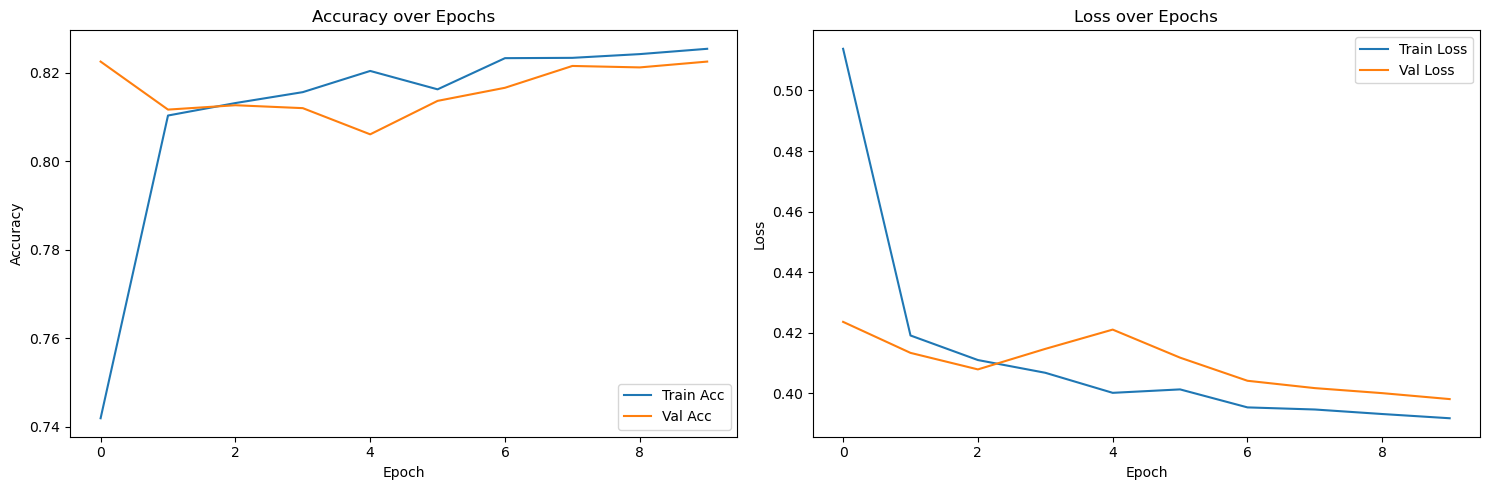

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
               precision    recall  f1-score   support

Not Cancerous       0.84      0.88      0.86      1981
    Cancerous       0.75      0.69      0.72      1061

     accuracy                           0.81      3042
    macro avg       0.80      0.78      0.79      3042
 weighted avg       0.81      0.81      0.81      3042



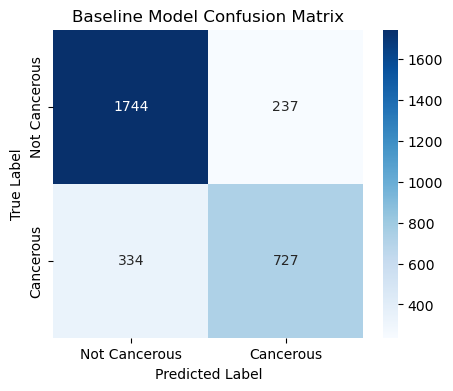

In [6]:
def plot_training(history):
    plt.figure(figsize=(15, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training(baseline_history)

# ------------------- Evaluate Baseline Model -------------------

# Predictions
y_probs_baseline = baseline_model_t1.predict(test_gen_t1_baseline)
y_preds_baseline = (y_probs_baseline >= 0.5).astype(int)

# Classification Report
print(classification_report(test_gen_t1_baseline.labels, y_preds_baseline, target_names=["Not Cancerous", "Cancerous"]))

# Confusion Matrix
cm_baseline = confusion_matrix(test_gen_t1_baseline.labels, y_preds_baseline)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Cancerous", "Cancerous"], yticklabels=["Not Cancerous", "Cancerous"])
plt.title("Baseline Model Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### **Results & Evaluation**
As shown in the graphs above, the model doesn’t show strong signs of overfitting or underfitting. The training and validation accuracy/loss curves are closely aligned, which suggests stable learning and good generalization, especially for a simple baseline and a binary classification task.

However, because this is a medical application, our focus should be on recall (correctly identifying all cancerous cases). In this context, false negatives (missed cancer cases) are much more harmful than false positives. While the model is reasonably well fit, its recall score of 69% indicates we’re still missing quiet some true cancer cases, which is a key area for improvement.

## **Optimized Model**
### **Data Augmentation**
- To help the model generalize better and prevent it from learning biases, we used **data augmentation** on the training set. This creates slightly varied versions of existing images using random rotations, shifts, zooming, and flips. By showing the model many different perspectives of the same class, it’s less likely to overfit to frequent patterns.

In [7]:
# --------------- OPTIMIZED MODEL --------------------
# Augment training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen_t1 = train_datagen.flow_from_dataframe(
    dataframe=train_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t1 = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_gen_t1 = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 14196 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.


### **Addressing the Class Imbalance**
- To handle the imbalance between cancerous and non-cancerous cells, we applied class weighting during training.
- By giving higher weight to cancerous samples, the model is penalized more when it misses them, encouraging it to reduce false negatives. This is especially important in cancer detection tasks, where missing a positive case is much more harmful than a false alarm.

In [8]:
# Compute class weights for binary classification
y_train_t1_int = train_labels_t1['isCancerous'].astype(int)
class_weights_t1 = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_t1_int
)
class_weight_dict_t1 = dict(enumerate(class_weights_t1))
print("Task 1 class weights:", class_weight_dict_t1)

Task 1 class weights: {0: 0.7675173010380623, 1: 1.4345189975747776}


## **Hyperparamter Tuning**
1. **Increased Model Depth**
    - Added more convolutional blocks (3 in total), increasing the number of filters from 32 → 64 → 128. This allows the model to learn richer, more abstract features from the images.

2. **More Training Epochs**
    - Increased from 10 (baseline) to 50. This gives the model more time to learn patterns in the data. When combined with data augmentation and a deeper architecture, it helps improve generalization.

3. **Regularization with Dropout**
    - Dropout layers force the network to learn more robust features by randomly deactivating neurons during training, helping to prevent overfitting.

In [9]:
# Define CNN
model_t1 = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Dropout(0.4),
    MaxPooling2D((2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_t1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

model_t1.summary()

history = model_t1.fit(
    train_gen_t1,
    validation_data=val_gen_t1,
    epochs=50,
    class_weight=class_weight_dict_t1,
    verbose=0
)
print("Optimized Model Training Completed")

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,137 (1.10 MB)

 Trainable params: 287,137 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Optimized Model Training Completed


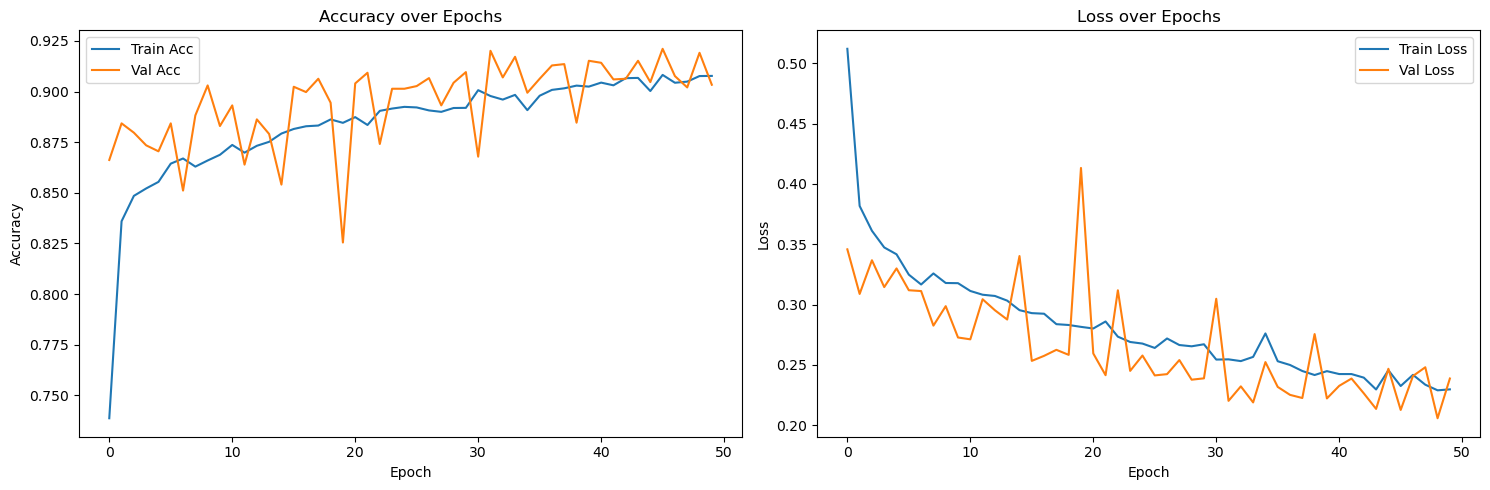

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step
               precision    recall  f1-score   support

Not Cancerous       0.95      0.90      0.92      1981
    Cancerous       0.83      0.92      0.87      1061

     accuracy                           0.90      3042
    macro avg       0.89      0.91      0.90      3042
 weighted avg       0.91      0.90      0.90      3042



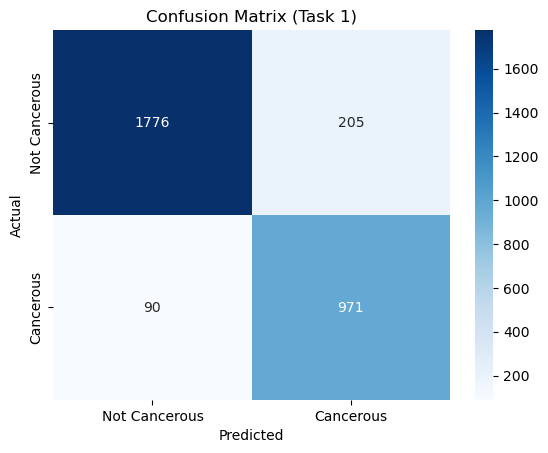

In [10]:
plot_training(history)

# Predict on test data
y_probs_t1 = model_t1.predict(test_gen_t1, verbose=1)
y_pred_final_t1 = (y_probs_t1 >= 0.5).astype(int)

# Classification report
print(classification_report(test_gen_t1.labels, y_pred_final_t1, target_names=["Not Cancerous", "Cancerous"]))

# Confusion matrix
cm_t1 = confusion_matrix(test_gen_t1.labels, y_pred_final_t1)
sns.heatmap(cm_t1, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Cancerous", "Cancerous"],
            yticklabels=["Not Cancerous", "Cancerous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Task 1)")
plt.show()

### **Final Model Evaluation and Justification**

- The final model showed clear improvements over the baseline, and those gains came from intentional design choices that helped the model learn better and generalize more effectively.

- Training and validation curves stayed close and followed similar trends, which shows the model wasn’t overfitting or underfitting.

- The deeper architecture (32–64–128 filters) helped the model pick up on more complex patterns, especially useful in medical imaging where subtle details matter. The improvements in validation performance confirmed that the extra depth was actually helping, not just memorizing.

- Regularization choices like dropout and data augmentation made the model more robust. Dropout helped prevent over-reliance on specific neurons, and augmentation added useful variability during training — improving the model’s ability to handle real-world variation in input images.

- Class weighting was also important. It ensured the model didn’t just aim for high accuracy by favoring the majority class, but instead learned to identify cancerous samples more effectively. This led to a major improvement in recall for the cancerous class, jumping from 69% to 92%, while precision and overall F1-score also increased.

These results show the model is much better at correctly identifying cancerous cases — only missing 8% — which is critical for medical applications. The overall balance of precision, recall, and F1-score across both classes suggests the model is both accurate and reliable.

#### **Evaluation Metrics**

| Class         | Precision | Recall | F1-score |
|---------------|-----------|--------|----------|
| Not Cancerous | 0.95      | 0.90   | 0.92     |
| Cancerous     | 0.83      | 0.92   | 0.87     |

- **Accuracy**: 90%  
- **Macro Avg F1-score**: 0.90  
- **Weighted Avg F1-score**: 0.90
